In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 
import numpy as np
import pickle
from scipy.misc import imread

from birdseye import BirdsEye
from lanefilter import LaneFilter
from curves import Curves
from helpers import show_images, save_image, roi

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
calibration_data = pickle.load(open("calibration_data.p", "rb" ))

matrix = calibration_data['camera_matrix']
distortion_coef = calibration_data['distortion_coefficient']

source_points = [(580, 460), (205, 720), (1110, 720), (703, 460)]
destination_points = [(320, 0), (320, 720), (960, 720), (960, 0)]

p = { 'sat_thresh': 120, 'light_thresh': 40, 'light_thresh_agr': 205,
      'grad_thresh': (0.7, 1.4), 'mag_thresh': 40, 'x_thresh': 20 }

birdsEye = BirdsEye(source_points, destination_points, matrix, distortion_coef)
laneFilter = LaneFilter(p)
curves = Curves(number_of_windows = 9, margin = 100, minimum_pixels = 50, 
                ym_per_pix = 30 / 720 , xm_per_pix = 3.7 / 700)

In [3]:
def pipeline_debug(img):
    
  ground_img = birdsEye.undistort(img)
  birdseye_img = birdsEye.sky_view(img)
    
  binary_img = laneFilter.apply(ground_img)
  sobel_img = birdsEye.sky_view(laneFilter.sobel_breakdown(ground_img))
  color_img = birdsEye.sky_view(laneFilter.color_breakdown(ground_img))
  
  wb = np.logical_and(birdsEye.sky_view(binary_img), roi(binary_img)).astype(np.uint8)
  result = curves.fit(wb)
    
  left_curve =  result['pixel_left_best_fit_curve']
  right_curve =  result['pixel_right_best_fit_curve']
    
  left_radius =  result['left_radius']
  right_radius =  result['right_radius']
  curve_debug_img = result['image']
  words = result['vehicle_position_words']

  projected_img = birdsEye.project(ground_img, binary_img, left_curve, right_curve)
    
  return birdseye_img, sobel_img, color_img, curve_debug_img, projected_img, left_radius, right_radius, words 

In [4]:
def pipeline_test(path):
  img = imread(path)
  birdseye_img, sobel_img, color_img, curve_debug_img, projected_img, left_radius, right_radius,words = pipeline_debug(img)
  print("left radius:", left_radius, "m |", "right radius:", right_radius, "m")
  print(words)
  show_images([birdseye_img, sobel_img, color_img], per_row = 3, per_col = 1, W = 15, H = 3)
  show_images([curve_debug_img, projected_img], per_row = 3, per_col = 1, W = 15, H = 3)

left radius: 1078.13371708 m | right radius: 1969.73258162 m
0.12 m right of center


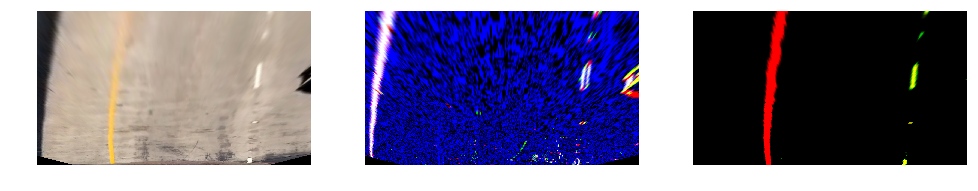

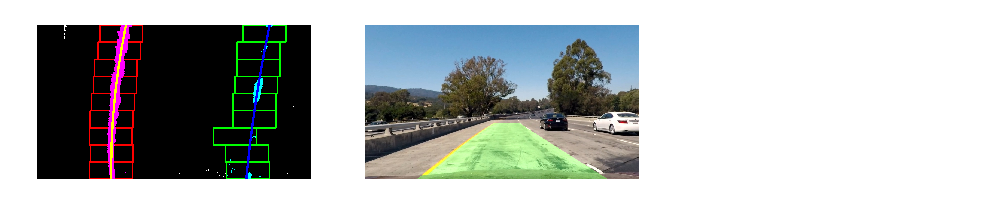

In [5]:
pipeline_test("test_images/test1.jpg")

left radius: 747.64561564 m | right radius: 50986.6579463 m
0.37 m right of center


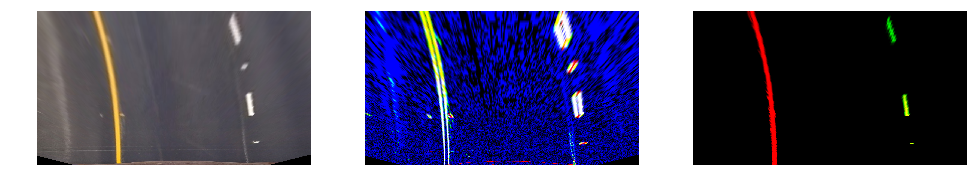

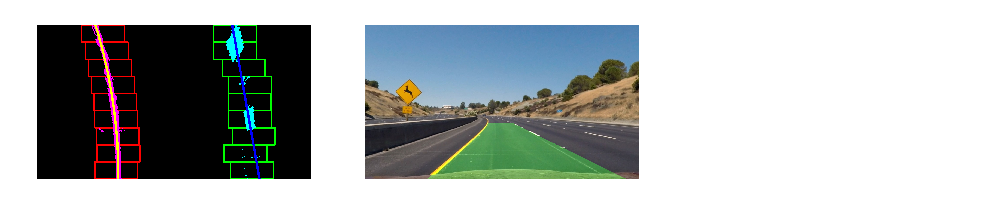

In [6]:
pipeline_test("test_images/test2.jpg")

left radius: 1250.19108027 m | right radius: 1188.16196536 m
0.11 m right of center


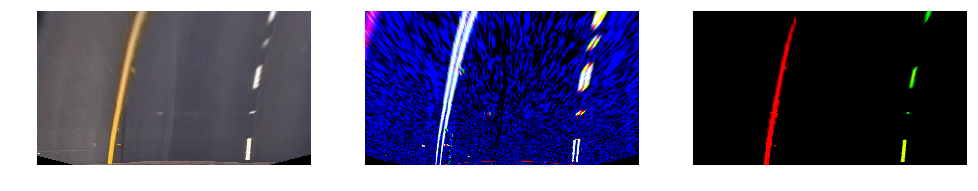

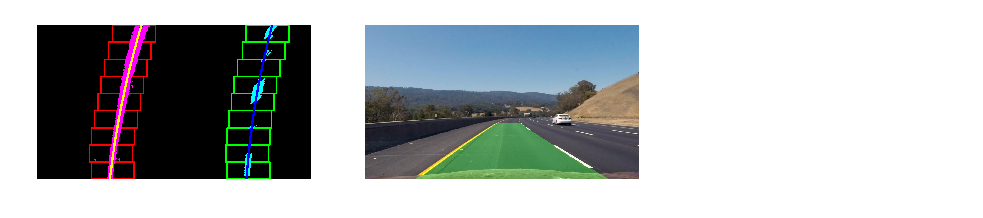

In [7]:
pipeline_test("test_images/test3.jpg")

left radius: 1444.51223171 m | right radius: 555.910177365 m
0.29 m right of center


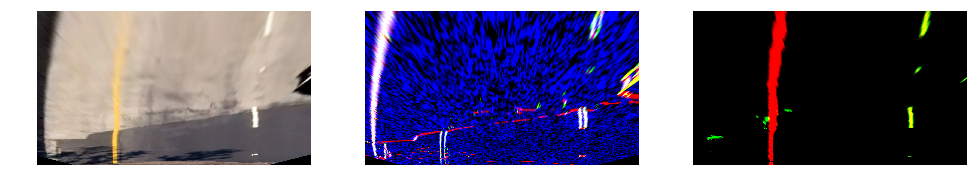

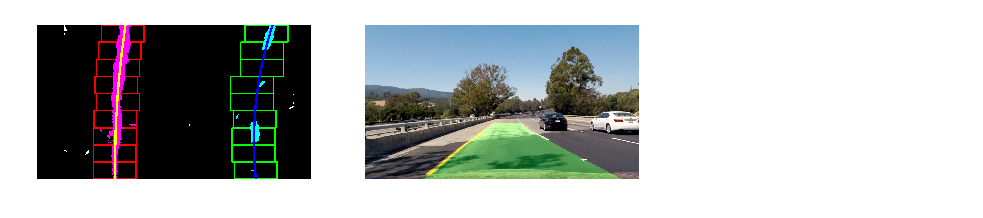

In [8]:
pipeline_test("test_images/test4.jpg")

left radius: 717.768638361 m | right radius: 1699.35267716 m
0.01 m left of center


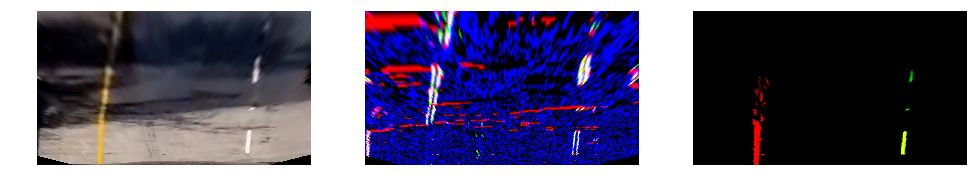

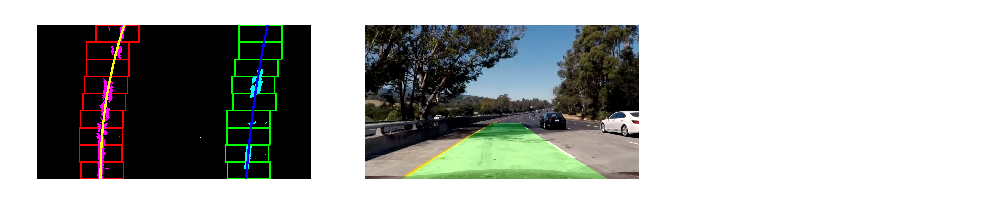

In [9]:
pipeline_test("test_images/test5.jpg")

left radius: 1193.06663527 m | right radius: 489.514971211 m
0.29 m right of center


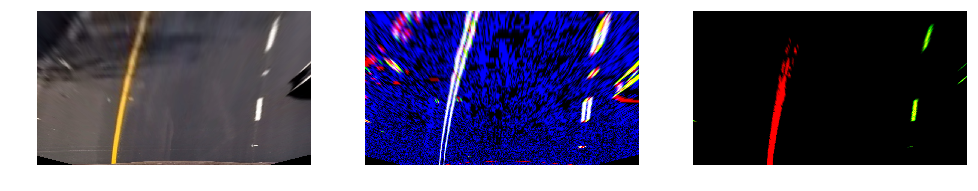

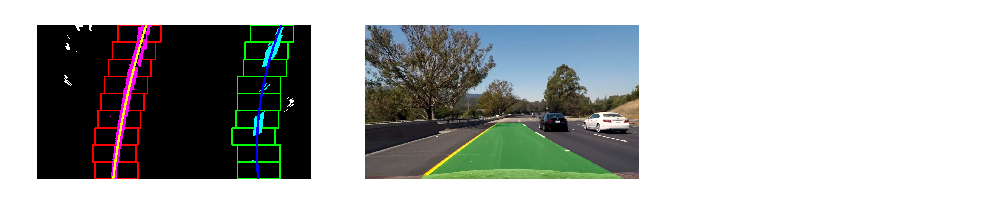

In [10]:
pipeline_test("test_images/test6.jpg")

left radius: 3717.07198514 m | right radius: 3946.5293317 m
0.01 m left of center


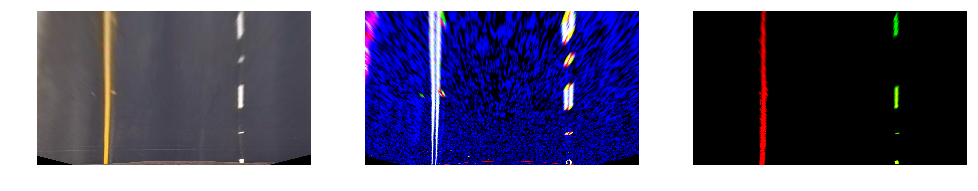

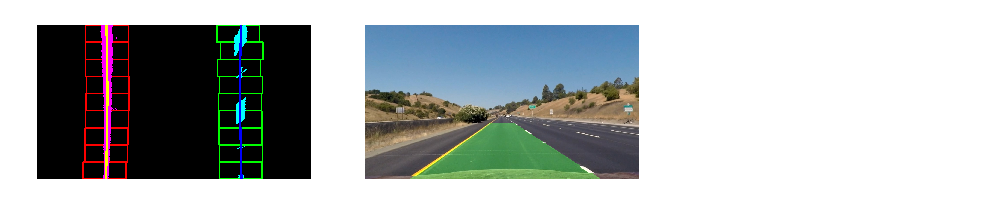

In [11]:
pipeline_test("test_images/straight_lines1.jpg")

left radius: 2367.68237982 m | right radius: 13164.6191332 m
0.01 m right of center


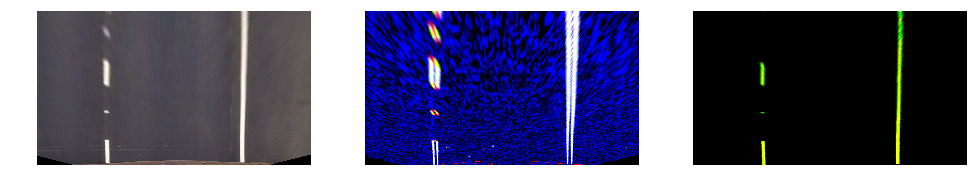

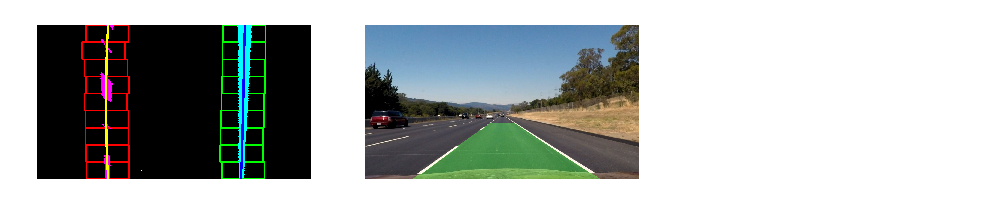

In [12]:
pipeline_test("test_images/straight_lines2.jpg")